# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Benjamin Shaar
- Brennan Jacobs
- An Ding
- Christopher David

## More Data Cleaning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
all_fighters = pd.read_csv('fighters.csv')

In [3]:
def assign_weight_class(weight):
    """
    Assigns a UFC weight class based on weight in pounds.
    
    Args:
        weight (float): Fighter's weight in pounds
        
    Returns:
        str: UFC weight class
    """
    if pd.isna(weight):
        return "Unknown"
    elif weight <= 125:
        return "Flyweight"
    elif weight <= 135:
        return "Bantamweight"
    elif weight <= 145:
        return "Featherweight"
    elif weight <= 155:
        return "Lightweight"
    elif weight <= 170:
        return "Welterweight"
    elif weight <= 185:
        return "Middleweight"
    elif weight <= 205:
        return "Light Heavyweight"
    else:
        return "Heavyweight"

# Apply the function to create a new weight class column
all_fighters['weight_class'] = all_fighters['Wt.'].apply(assign_weight_class)

weight_class_distribution = all_fighters['weight_class'].value_counts()
print(weight_class_distribution)

weight_class
Welterweight         654
Lightweight          650
Middleweight         548
Featherweight        489
Heavyweight          479
Bantamweight         479
Flyweight            453
Light Heavyweight    434
Unknown               86
Name: count, dtype: int64


In [4]:
# Calculate total fights for each fighter
all_fighters['total_fights'] = all_fighters['W'] + all_fighters['L'] + all_fighters['D']

# Calculate win percentage
all_fighters['win_percentage'] = all_fighters['W'] / all_fighters['total_fights']

# Handle potential division by zero (fighters with no fights)
all_fighters['win_percentage'] = all_fighters['win_percentage'].fillna(0)

# Round to 3 decimal places for readability
all_fighters['win_percentage'] = round(all_fighters['win_percentage'], 3)

# View the results
print(all_fighters[['First', 'Last', 'W', 'L', 'D', 'total_fights', 'win_percentage']].head(10))


weight_class_stats = all_fighters.groupby('weight_class').agg({
    'Ht.': 'mean',
    'Reach': 'mean',
    'W': 'mean',
    'L': 'mean',
    'win_percentage': 'mean',  
    'First': 'count'  
}).rename(columns={'First': 'fighter_count'})

print(weight_class_stats)

      First          Last   W   L  D  total_fights  win_percentage
0       Tom         Aaron   5   3  0             8           0.625
1     Danny        Abbadi   4   6  0            10           0.400
2   Nariman       Abbasov  28   4  0            32           0.875
3     David        Abbott  10  15  0            25           0.400
4     Hamdy    Abdelwahab   6   0  0             6           1.000
5    Mansur   Abdul-Malik   8   0  0             8           1.000
6    Shamil  Abdurakhimov  20   8  0            28           0.714
7  Hiroyuki           Abe   8  15  3            26           0.308
8    Daichi           Abe   6   2  0             8           0.750
9      Papy         Abedi  10   4  0            14           0.714
                         Ht.      Reach          W         L  win_percentage  \
weight_class                                                                   
Bantamweight       67.135255  68.672619  12.093946  5.121086        0.696643   
Featherweight      68.4

In [5]:
# Remove fighters with missing height, weight, or reach data
clean_fighters = all_fighters.dropna(subset=['Ht.', 'Wt.', 'Reach'])

# Remove fighters with unknown weight class
clean_fighters = clean_fighters[clean_fighters['weight_class'] != "Unknown"]

# Reset the index after dropping rows
clean_fighters = clean_fighters.reset_index(drop=True)

print(clean_fighters)

        First          Last      Nickname   Ht.    Wt.  Reach      Stance   W  \
0     Nariman       Abbasov     Bayraktar  68.0  155.0   66.0    Orthodox  28   
1       Hamdy    Abdelwahab    The Hammer  74.0  264.0   72.0    Southpaw   6   
2      Mansur   Abdul-Malik           NaN  74.0  185.0   79.0    Orthodox   8   
3      Shamil  Abdurakhimov         Abrek  75.0  235.0   76.0    Orthodox  20   
4      Daichi           Abe           NaN  71.0  170.0   71.0    Orthodox   6   
...       ...           ...           ...   ...    ...    ...         ...  ..   
2339  Zhalgas    Zhumagulov           NaN  64.0  125.0   66.0      Switch  14   
2340    Fares          Ziam  Smile Killer  73.0  155.0   75.0    Orthodox  17   
2341      Cat       Zingano         Alpha  66.0  145.0   68.0    Southpaw  10   
2342    Allan        Zuniga         Tigre  67.0  155.0   70.0    Orthodox  13   
2343   Virgil       Zwicker        RezDog  74.0  205.0   74.0  Unrecorded  15   

      L  D  Belt       weig

### Attempt 1 - Linear Regression

In [6]:
# Function to fit and evaluate the model
def evaluate_model(X, y, title, model_type='linear'):
    """
    Fit a regression model and check assumptions with diagnostic plots.
    
    Args:
        X (array): array with feature values
        y (array): array with target values
        title (str): title of the model for the graph
        model_type (str): 'linear' or 'rf' for RandomForest
    
    Returns:
        model: The trained model
        mse: Mean squared error
        r2: R-squared value
    """
    
    #split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse}")
    r2 = r2_score(y_test, y_pred)
    print(f"{title} - R²: {r2}")
    
    
    residuals = y_test - y_pred
    
    
    plt.figure(figsize=(16, 12))
    
    # 1. Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Win Percentage')
    plt.ylabel('Predicted Win Percentage')
    plt.title('Actual vs Predicted')
    
    
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    
    
    
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return model, mse, r2


Model 1: Physical Attributes
Physical Attributes Model - Mean Squared Error: 0.012150818505786502
Physical Attributes Model - R²: 0.007486355707778669


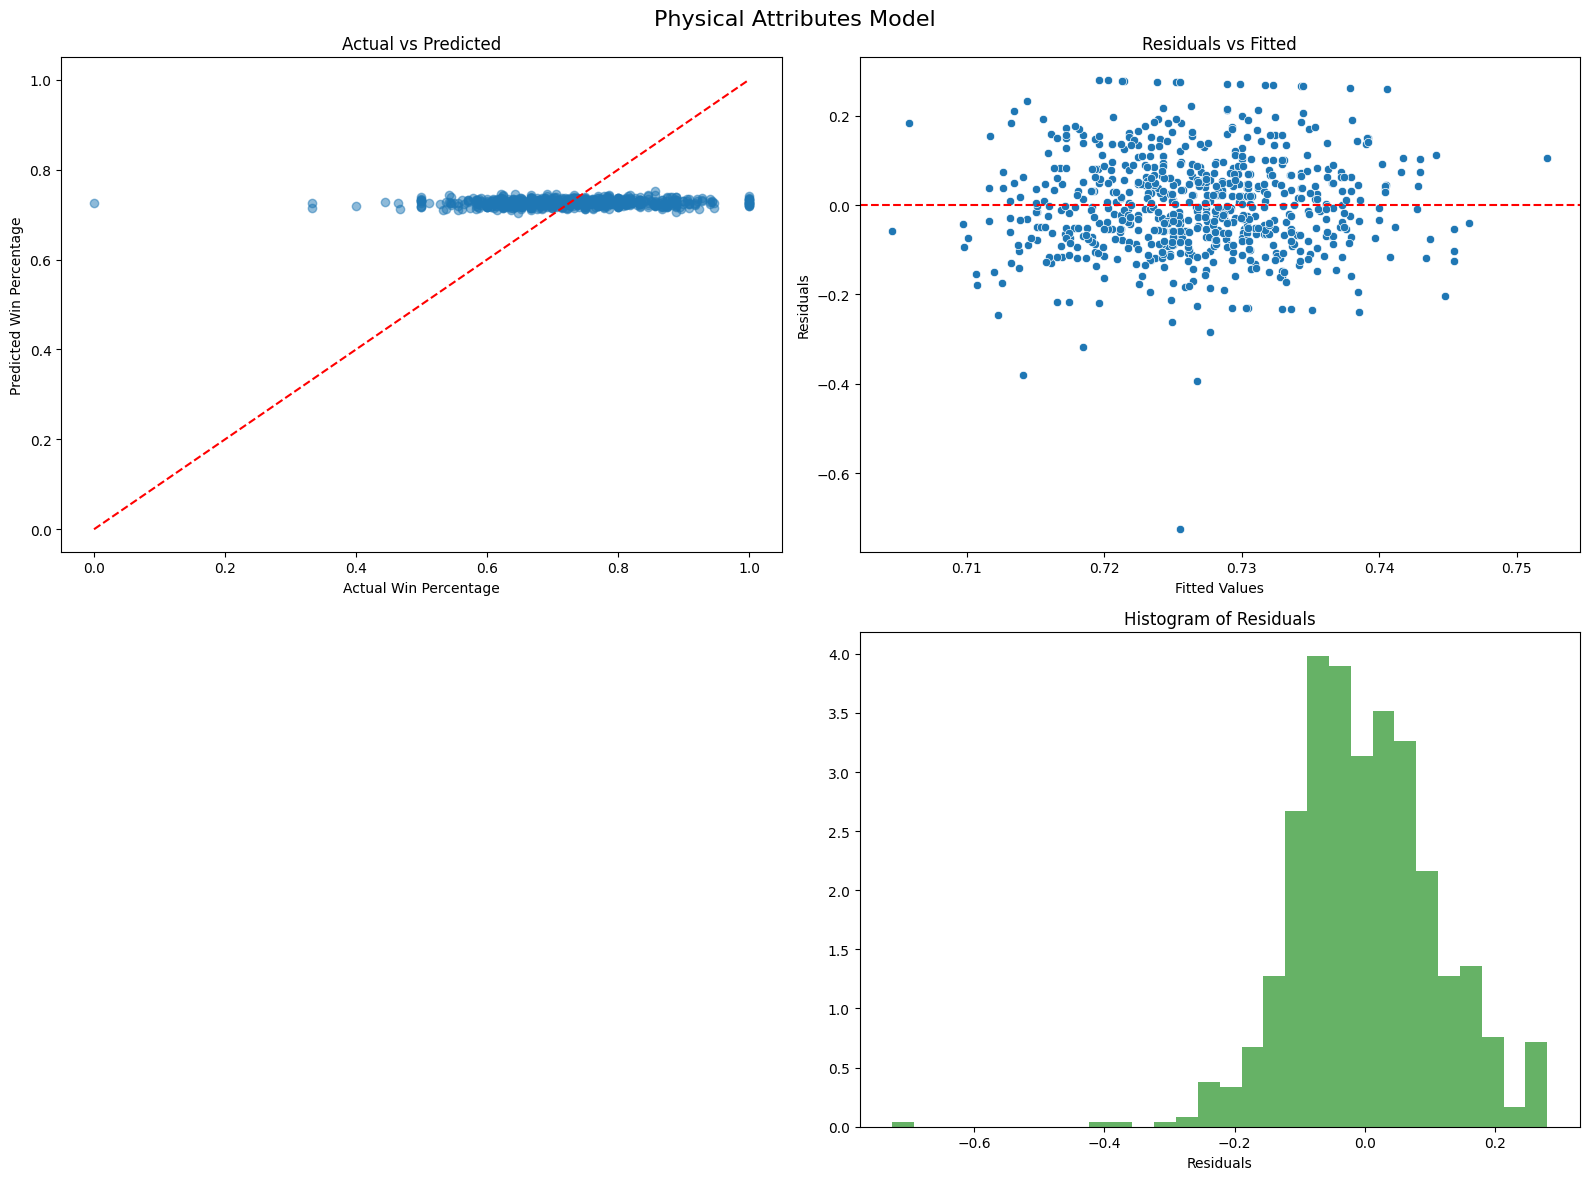


Model 2: Stance Analysis
Stance Analysis Model - Mean Squared Error: 0.01217521053381766
Stance Analysis Model - R²: 0.005493945021917912


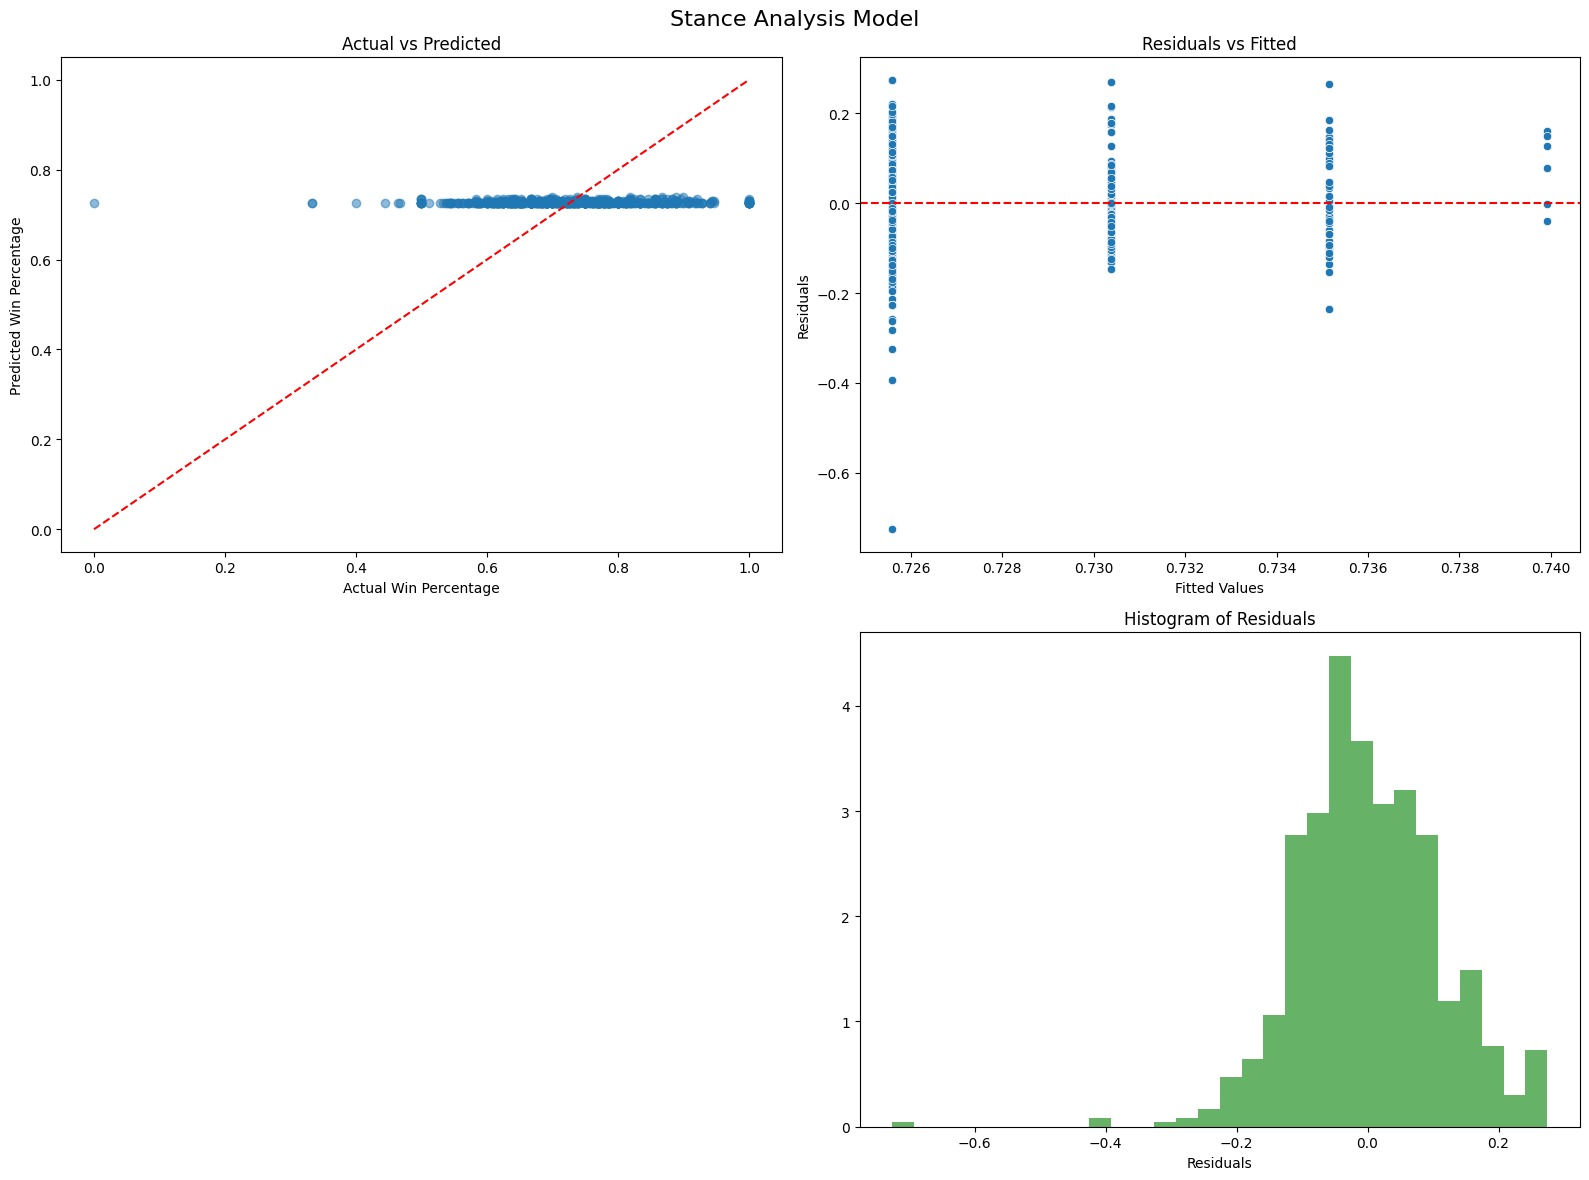


Model 3: Combined Physical and Stance
Combined Physical and Stance Model - Mean Squared Error: 0.012083963622380726
Combined Physical and Stance Model - R²: 0.012947253995099661


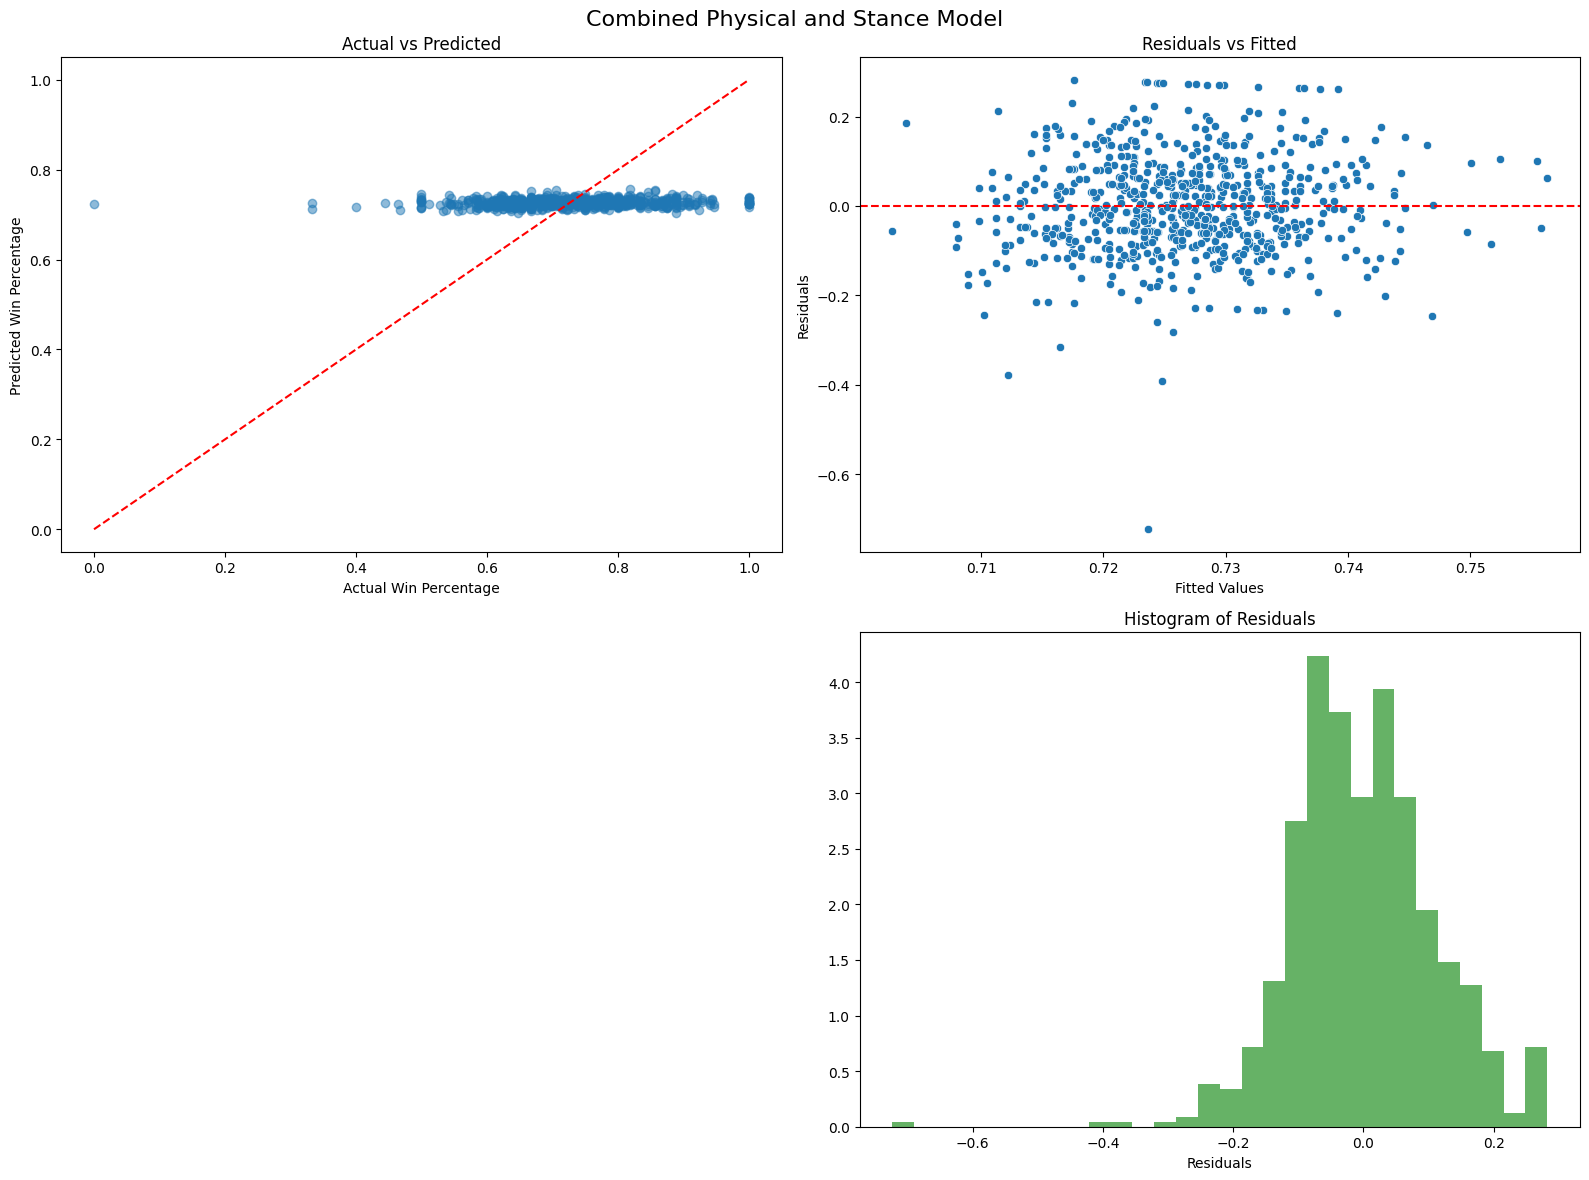

In [7]:
# Main function to answer the MMA fighter analysis question
def main():
    """
    Analyzes MMA fighter data to determine which physical attributes and fighting styles
    contribute most to success in the octagon.
    
    Returns:
        Evaluated models for different feature sets along with diagnostic plots
    """
    try:
        # Load the MMA fighter dataset
        df = clean_fighters 
        
        df['Stance'] = df['Stance'].astype('category').cat.codes
        
        
        df = df.fillna(df.mean(numeric_only=True))
        
            
        y = df['win_percentage']
        
        # Model 1: Physical Attributes
        print("\nModel 1: Physical Attributes")
        physical_columns = ['Ht.', 'Wt.', 'Reach']
        X_physical = df[physical_columns].copy()
        evaluate_model(X_physical, y, "Physical Attributes Model")
        
        # Model 2: Stance Analysis
        print("\nModel 2: Stance Analysis")
        X_stance = df[['Stance']].copy()
        evaluate_model(X_stance, y, "Stance Analysis Model")
        
        # Model 3: Combined Physical and Stance
        print("\nModel 3: Combined Physical and Stance")
        X_combined = df[physical_columns + ['Stance']].copy()
        evaluate_model(X_combined, y, "Combined Physical and Stance Model")
    
    except FileNotFoundError:
        print("File not found. Please check the path to your MMA fighter dataset.")
    except ValueError as e:
        print(f"Error in data processing: {str(e)}")
    # except Exception as e:
        # print(f"An unexpected error occurred: {str(e)}")

# Run the main function
if __name__ == '__main__':
    main()

## Preliminary Result

### Phase Overview
In phase 3, we extended our analysis from Phase 2 by formally estimating the predictive model using the cleaned dataset (fighters.csv), and decided to build some linear regression models to predict the outcome of MMA matches using features of physical only, stance only, and a combination of physical and stance. By implementing these models, we aim further to explore the relationship between physical attributes and fight outcomes, helping to determine which factors contribute most to success in the octagon.

### Assumption Check 
- Linearity & Homoscedasticity: For all 3 models, we created scatterplots on residuals and observed that the residuals are spread in a random pattern around 0, which confirms the linearity check. At the same time, the residual plots helped us pass the homoscedasticity check as there was no obvious funnel shape in the plots.
- Normality: For all 3 models, we also created a histogram that shows the distribution of residuals. We observe that the residuals are approximately normally distributed, which indicates the normality of our data.

### Model Performance & Measure of Fits
The models are evaluated based on MSE and R square.
- MSE: All models showed a similar MSE of approximately 0.012. We created a scatterplot that shows the actual vs. predicted value to help visualize model performance.
R square: The R square of all 3 models is low (0.007, 0.005, 0.013), indicating that the models' ability to explain the variance of the dependent variable (match outcome) is very limited and that the current predictors are insufficient in predicting match outcomes. 

### Future Improvement
- Additional Features: Since we have experienced a very low R square, we plan to incorporate additional features from our dataset that may better represent the complexities of MMA performance to increase our R square to an optimal level. 
- More Models: We also plan to build more complex non-linear models to capture more complex relationships; this might include polynomial regression and classification models like random forest.

### Potential Ethical Considerations
- The application of physical qualities merged with fighting stances to forecast MMA results generates ethical problems that stem from technical and non-technical prejudice. The use of **representational bias** occurs when a predictive model prevents accurate representation of fighters who do not align with physical stereotypes, thus causing group exclusion. Allocative bias takes place when decision-makers distribute resources unequally to fighters based on characteristics that indicate success, leading to fewer fighters from diverse backgrounds in MMA. Identification of these biases remains challenging, though their consequences may be severe because they strengthen ethnic stereotypes and create unrealistic fighter profiles. 
